In [1]:
# Install or upgrade Ray Tune
!pip install -U ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 MB 16.5 MB/s eta 0:00:00


In [2]:
# Step 1: Import libraries
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, ConcatDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from ray import tune
from ray.air import session
from ray.tune import with_parameters
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Step 2: Load and Split the CIFAR-100 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5071, 0.4867, 0.4408),  # CIFAR-100 mean
        (0.2675, 0.2565, 0.2761)   # CIFAR-100 std
    )
])
cifar100_train = datasets.CIFAR100(
    root='.', train=True, download=True, transform=transform)
cifar100_test = datasets.CIFAR100(
    root='.', train=False, download=True, transform=transform)
train_size = int(0.8 * len(cifar100_train))
valid_size = len(cifar100_train) - train_size
sub_train, valid = random_split(cifar100_train, [train_size, valid_size])

# Global batch size
batch_size = 128

100%|██████████| 169M/169M [00:01<00:00, 94.8MB/s]


Extracting ./cifar-100-python.tar.gz to .
Files already downloaded and verified


In [4]:
# Step 3: Define the Model Architecture
class EasyCNN(nn.Module):
    def __init__(self, activation='relu'):
        super(EasyCNN, self).__init__()
        self.activation = activation
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Output: 16x16x32
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 100)  # 100 classes for CIFAR-100

    def forward(self, x):
        x = self.conv1(x)
        x = self.apply_activation(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.apply_activation(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.fc1(x)
        return x

    def apply_activation(self, x):
        if self.activation == 'relu':
            return F.relu(x)
        elif self.activation == 'leaky_relu':
            return F.leaky_relu(x)
        elif self.activation == 'elu':
            return F.elu(x)
        else:
            raise ValueError('Unknown activation function')


In [1]:
# Step 4: Define the Hyperparameter Tuning Function
def tune_hyperparameters():
    # Define hyperparameter search space
    search_space = {
        'activation': tune.choice(['relu', 'leaky_relu', 'elu']),
        'optimizer': tune.choice(['SGD', 'Adam', 'RMSprop']),
        'lr': tune.loguniform(1e-4, 1e-2),
        'batch_size': tune.choice([64, 128, 256]),
    }

    def train_model(config, sub_train=None, valid=None):
        batch_size = config['batch_size']
        # DataLoaders for the current trial
        train_loader = DataLoader(
            sub_train, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(
            valid, batch_size=batch_size, shuffle=False)

        model = EasyCNN(activation=config['activation'])
        optimizer_name = config['optimizer']
        lr = config['lr']
        if optimizer_name == 'SGD':
            optimizer = optim.SGD(
                model.parameters(), lr=lr, momentum=0.9)
        elif optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=lr)
        else:
            raise ValueError('Unknown optimizer')

        criterion = nn.CrossEntropyLoss()
        num_epochs = 10  # Adjust as needed
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            for data, target in train_loader:
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
            # Validation phase
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for data, target in valid_loader:
                    output = model(data)
                    _, predicted = torch.max(output.data, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()
            validation_accuracy = correct / total
            session.report({'validation_accuracy': validation_accuracy})

   # Use tune.with_parameters to pass sub_train and valid to train_model
   # Encountered problem size with raytune when size >96MB
    trainable = tune.with_parameters(
        train_model, sub_train=sub_train, valid=valid)

    # Run Ray Tune
    analysis = tune.run(
        trainable,
        # Adjust based on available resources
        # use TPU on Google Colab
        resources_per_trial={"cpu": 96},
        config=search_space,
        num_samples=10,  # Number of trials
        metric="validation_accuracy",
        mode="max",
        verbose=1,
        name="tune_cifar100_hyperparameters"
    )

    # Get the results DataFrame
    df = analysis.results_df

    # Print the columns to see what is available
    print("Columns in results_df:")
    print(df.columns)

    # Get the best 3 hyperparameter configurations
    top3 = df.sort_values(
        'validation_accuracy', ascending=False).head(3)

    # Updated hyperparameter columns with 'config/' prefix
    hyperparam_columns = ['config/activation', 'config/optimizer', 'config/lr', 'config/batch_size']

    # Extract configurations for the top 3 trials
    top3_configs = []
    for _, row in top3.iterrows():
        config = {param.split('/')[-1]: row[param] for param in hyperparam_columns}
        top3_configs.append(config)

    return top3_configs

In [6]:
# Step 5: Run Hyperparameter Tuning to Find the Top 3 Configurations
print("Running hyperparameter tuning...")
top3_configs = tune_hyperparameters()
print("\nTop 3 configurations based on validation accuracy:")
for idx, config in enumerate(top3_configs):
    print(f"\nConfiguration {idx+1}:")
    print(config)

Running hyperparameter tuning...


2024-11-21 23:46:44,486	INFO worker.py:1819 -- Started a local Ray instance.
2024-11-21 23:46:48,197	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.


+------------------------------------------------------------------+
| Configuration for experiment     tune_cifar100_hyperparameters   |
+------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator           |
| Scheduler                        FIFOScheduler                   |
| Number of trials                 10                              |
+------------------------------------------------------------------+

View detailed results here: /root/ray_results/tune_cifar100_hyperparameters
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-11-21_23-46-42_619960_675/artifacts/2024-11-21_23-46-48/tune_cifar100_hyperparameters/driver_artifacts`

Trial status: 10 PENDING
Current time: 2024-11-21 23:46:48. Total running time: 0s
Logical resource usage: 0/96 CPUs, 0/0 GPUs (0.0/4.0 TPU, 0.0/1.0 accelerator_type:TPU-V2)
+-------------------------------------------------------------------

2024-11-22 00:17:28,866	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/tune_cifar100_hyperparameters' in 0.0069s.



Trial train_model_df86b_00009 completed after 10 iterations at 2024-11-22 00:17:28. Total running time: 30min 40s
+--------------------------------------------------+
| Trial train_model_df86b_00009 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         16.6973 |
| time_total_s                             169.034 |
| training_iteration                            10 |
| validation_accuracy                        0.352 |
+--------------------------------------------------+

Trial status: 10 TERMINATED
Current time: 2024-11-22 00:17:28. Total running time: 30min 40s
Logical resource usage: 96.0/96 CPUs, 0/0 GPUs (0.0/4.0 TPU, 0.0/1.0 accelerator_type:TPU-V2)
Current best trial: df86b_00001 with validation_accuracy=0.3799 and params={'activation': 'elu', 'optimizer': 'RMSprop', 'lr': 0.00031888713459247314, 'batch_size': 64}
+--------------------------------------------------

In [21]:
# Combine sub-training and validation datasets
full_train_dataset = ConcatDataset([sub_train, valid])

def retrain_and_evaluate(config):
    print(f"configuration details:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    batch_size = config['batch_size']
    train_loader = DataLoader(
        full_train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(
        cifar100_test, batch_size=batch_size, shuffle=False)

    model = EasyCNN(activation=config['activation'])
    optimizer_name = config['optimizer']
    lr = config['lr']
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(
            model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError('Unknown optimizer')

    criterion = nn.CrossEntropyLoss()
    num_epochs = 50  # Increase epochs for full training
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        correct = 0
        total = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * data.size(0)
            # Calculate training accuracy
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)
        if epoch == 0:
          print(
              f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}')
        if epoch % 5 == 4:
          print(
              f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}')

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy:.4f}')

    # Plot training loss and accuracy
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(
        f"Training Loss (Activation: {config['activation']}, Optimizer: {config['optimizer']})")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(
        f"Training Accuracy (Activation: {config['activation']}, Optimizer: {config['optimizer']})")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return test_accuracy


Retraining and evaluating model with configuration 1...
configuration details:
  activation: elu
  optimizer: RMSprop
  lr: 0.00031888713459247314
  batch_size: 64
Epoch [1/50], Train Loss: 3.2729, Train Accuracy: 0.2348
Epoch [5/50], Train Loss: 1.9028, Train Accuracy: 0.5166
Epoch [10/50], Train Loss: 1.1405, Train Accuracy: 0.7020
Epoch [15/50], Train Loss: 0.5909, Train Accuracy: 0.8458
Epoch [20/50], Train Loss: 0.2603, Train Accuracy: 0.9351
Epoch [25/50], Train Loss: 0.1189, Train Accuracy: 0.9725
Epoch [30/50], Train Loss: 0.0702, Train Accuracy: 0.9842
Epoch [35/50], Train Loss: 0.0489, Train Accuracy: 0.9886
Epoch [40/50], Train Loss: 0.0360, Train Accuracy: 0.9915
Epoch [45/50], Train Loss: 0.0303, Train Accuracy: 0.9930
Epoch [50/50], Train Loss: 0.0266, Train Accuracy: 0.9940
Test Accuracy: 0.3542


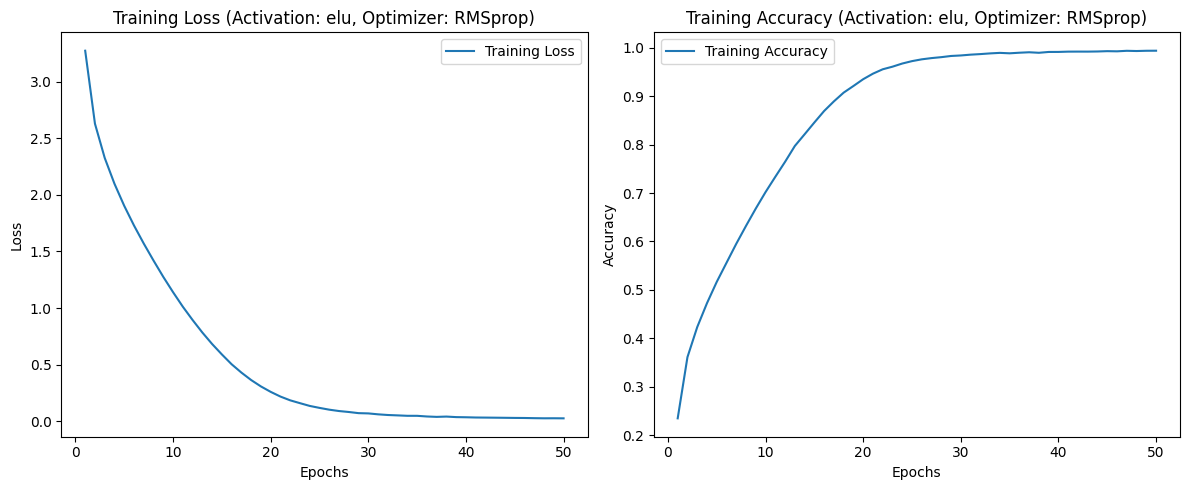


Retraining and evaluating model with configuration 2...
configuration details:
  activation: leaky_relu
  optimizer: RMSprop
  lr: 0.0011039597810681766
  batch_size: 64
Epoch [1/50], Train Loss: 3.4217, Train Accuracy: 0.2056
Epoch [5/50], Train Loss: 1.4276, Train Accuracy: 0.6225
Epoch [10/50], Train Loss: 0.3827, Train Accuracy: 0.8898
Epoch [15/50], Train Loss: 0.1196, Train Accuracy: 0.9634
Epoch [20/50], Train Loss: 0.0741, Train Accuracy: 0.9771
Epoch [25/50], Train Loss: 0.0598, Train Accuracy: 0.9812
Epoch [30/50], Train Loss: 0.0526, Train Accuracy: 0.9842
Epoch [35/50], Train Loss: 0.0499, Train Accuracy: 0.9856
Epoch [40/50], Train Loss: 0.0474, Train Accuracy: 0.9863
Epoch [45/50], Train Loss: 0.0446, Train Accuracy: 0.9869
Epoch [50/50], Train Loss: 0.0448, Train Accuracy: 0.9874
Test Accuracy: 0.3541


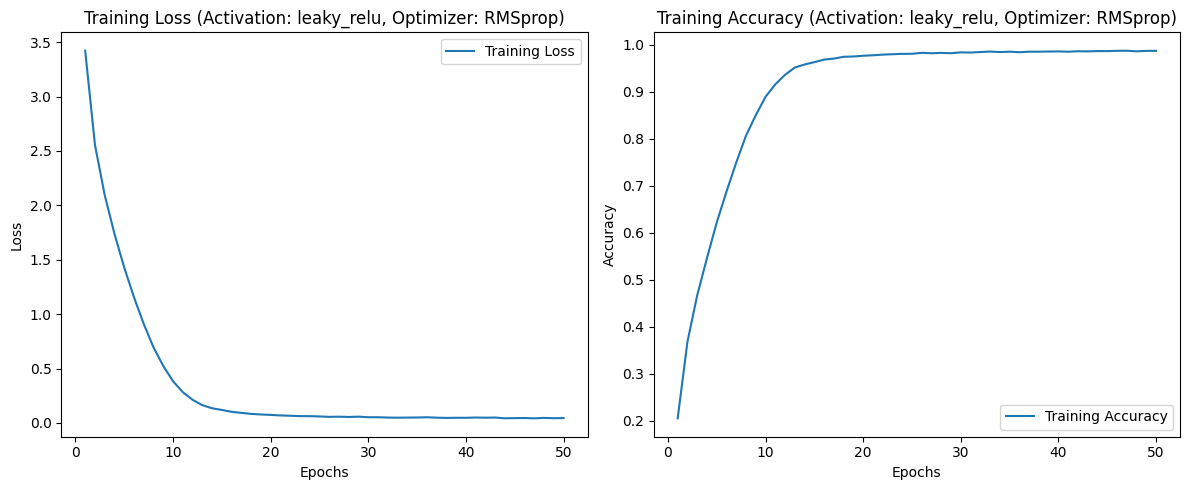


Retraining and evaluating model with configuration 3...
configuration details:
  activation: relu
  optimizer: RMSprop
  lr: 0.002348571968972013
  batch_size: 128
Epoch [1/50], Train Loss: 3.7492, Train Accuracy: 0.1672
Epoch [5/50], Train Loss: 2.2493, Train Accuracy: 0.4280
Epoch [10/50], Train Loss: 1.5874, Train Accuracy: 0.5753
Epoch [15/50], Train Loss: 1.1282, Train Accuracy: 0.6840
Epoch [20/50], Train Loss: 0.8416, Train Accuracy: 0.7544
Epoch [25/50], Train Loss: 0.6500, Train Accuracy: 0.8041
Epoch [30/50], Train Loss: 0.5217, Train Accuracy: 0.8377
Epoch [35/50], Train Loss: 0.4335, Train Accuracy: 0.8630
Epoch [40/50], Train Loss: 0.3625, Train Accuracy: 0.8826
Epoch [45/50], Train Loss: 0.3090, Train Accuracy: 0.8988
Epoch [50/50], Train Loss: 0.2746, Train Accuracy: 0.9086
Test Accuracy: 0.2845


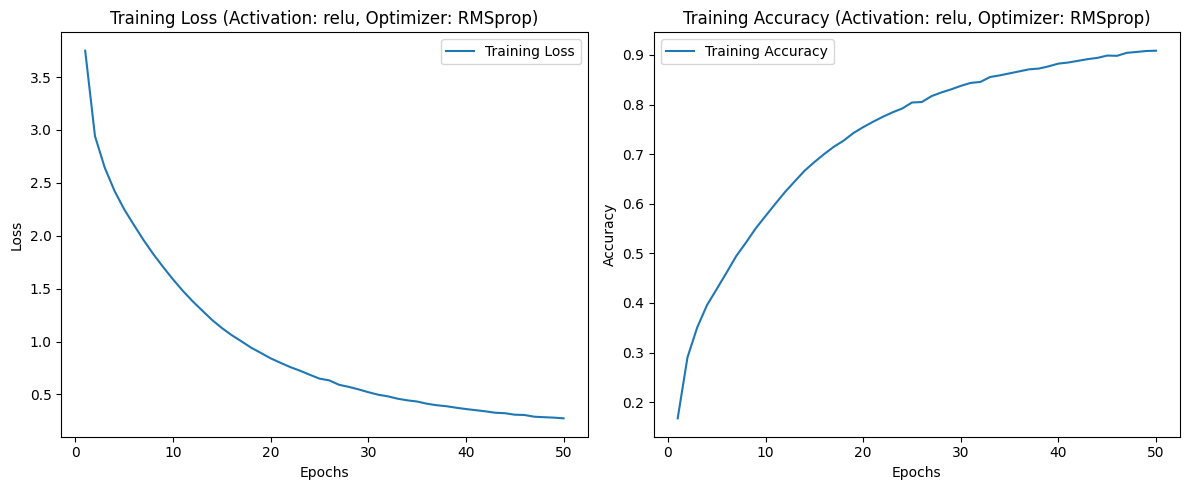


Test accuracies of the top 3 configurations:
Configuration 1 Test Accuracy: 0.3542
Configuration 2 Test Accuracy: 0.3541
Configuration 3 Test Accuracy: 0.2845


In [22]:
# Step 7: Evaluate the Models on the Test Dataset and Plot Training Loss Curves
test_accuracies = []
for idx, config in enumerate(top3_configs):
    print(f"\nRetraining and evaluating model with configuration {idx+1}...")
    test_accuracy = retrain_and_evaluate(config)
    test_accuracies.append(test_accuracy)

# Summarize Test Accuracies
print("\nTest accuracies of the top 3 configurations:")
for idx, accuracy in enumerate(test_accuracies):
    print(f"Configuration {idx+1} Test Accuracy: {accuracy:.4f}")